<a href="https://colab.research.google.com/github/ShreshthSaxena/ML/blob/master/detectron_2_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A honest implementation of Facebook's Detectron2

roberto.sannazzaro@gmailcom


Among many different techniques for object detection Facebook came up with its model: Detectron2. This model, similarly to Yolos models is able to draw bounding boxes around objects and inference with a panoptic segmentation model, in other words, instead of drawing a box around an object it "wraps" the object bouding its real borders (Think of it as the smart snipping tool from photoshop.




# Introduction
The purpose of this guide is to show how to easely implement a pretrained Detectron2 model, able to recognize objects represented by the classes from the [COCO](http://cocodataset.org/#home) (Common Object in COntext) dataset.
This guide is meant to provide a starting point for a beginner in computer vision, it aims at explaining what are the first steps to implement a pre-trained model, and its final goal is to spike your interest into learning more, and arranging your thoughts in this overwhleming field.
I provide a Google Colab Notebook that you can clone and use as you want.


# Installing the dependencies

To get started its core dependencies must be installed:
- PyTorch
- Cython
- Detectron2
- OpenCV

Those tasks can take several minutes, and since you need a GPU to run this notebook, I advice you to clone my Colab notebook and write everything from Google Colab, this will also help you become more confident with command line snippets and file management in cloud!

In [0]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo
#!pip install opencv-python Google Colab already comes with OpenCV

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 55.6MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=69d344d5dc6ebe9504ed852d120b0277a048552b5b4dd3007f15d738daa44c3d
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-gju6l9wy
  Running command git 

# Importing the libraries and needed files

Once those dependecies are installed you will most probably need to restart your runtine / kernel.
Now we need to import some libraries we will need to import, process and infers predictions, among those libraries we have ......

Since I am using Google Colab, the function `cv2.imshow()` is not available, and I need to use a "patched" version of it, if you are running this notebook on your local machine get rid of it.

In [0]:
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow # On your local machine you don't need it.

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In this guide I am using an image from my google drive, you can mount your Google Drive and use an image of your choice:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's now get a picture for which we want to run our model:

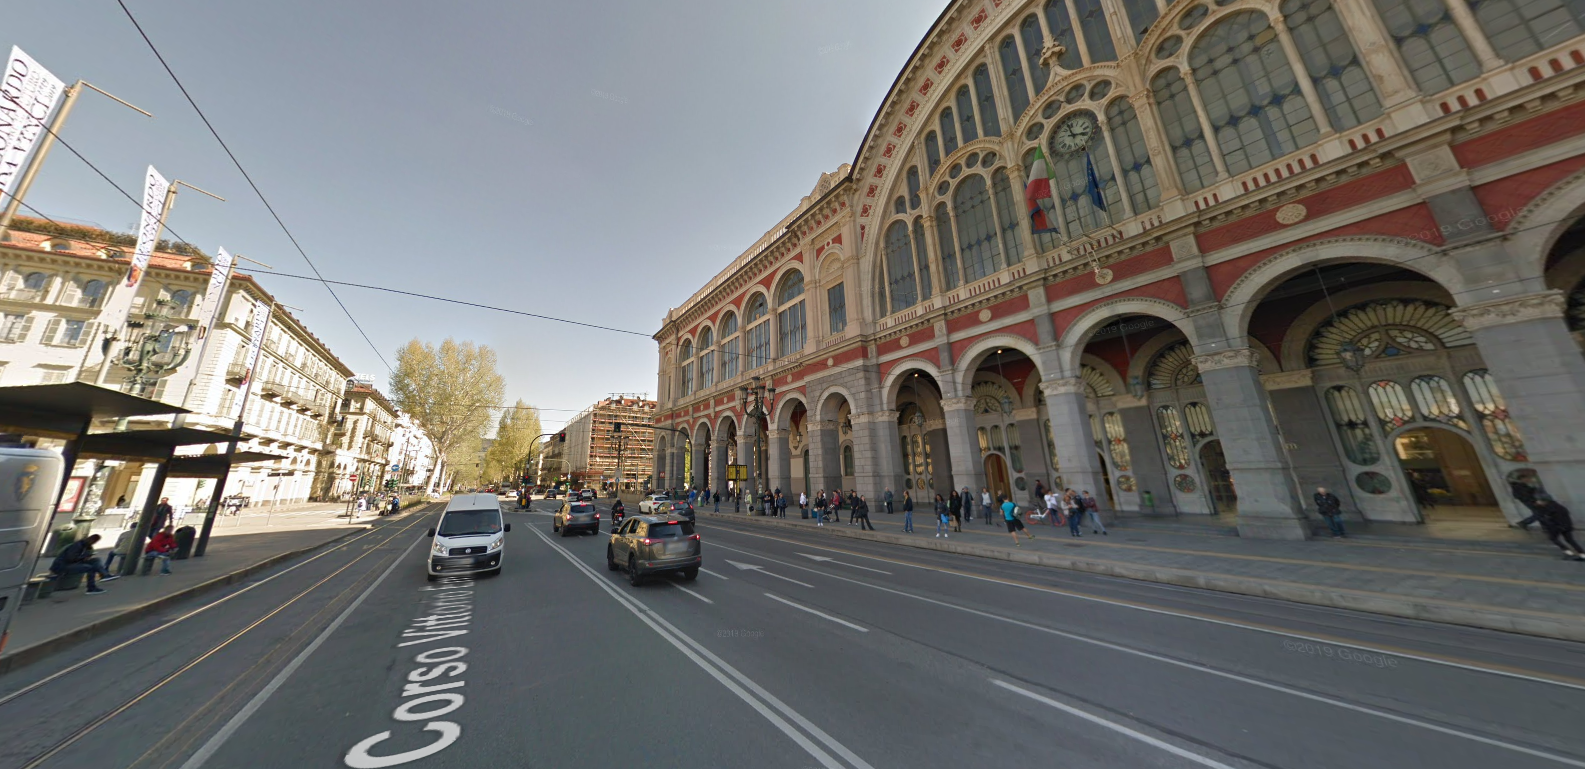

In [0]:
im = cv2.imread("./drive/My Drive/turin.png")
cv2_imshow(im)

# Fitting the model
Once our image is loaded, we need to load our model and a little bit of configuration. First, we load the configurations from Detectron, and then we apply to it a custom configuration coming from COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml. Then the threshold is set, hence the sensitivity of the model while detecting objects (play with these parameters!). 

The next step consists of loading the checkpoints relative to this model, in other words, the model itself in .pklformat.

The next step consists in instantiating the model itself, think like the same you do in scikit-learn when for example you want to make a regression:
reg = LinearRegression() reg.fit(X, y) reg.predict(X_test) However, instead of passing to our predictor an array X_train we pass our image, which corresponds as well in an array (a 3D array to be precise: one axis for the width, another for the height and the last one representing the colors of the image).

The reason we are using a pre-trained model, instead of training our model can be explained by the first two lines the description file from detectron2/MODEL_ZOO:
"This file documents a large collection of baselines trained with detectron2 in Sep-Oct, 2019. All numbers were obtained on Big Basin servers with 8 NVIDIA V100 GPUs & NVLink. The software in use was PyTorch 1.3, CUDA 9.2, cuDNN 7.4.2 or 7.6.3.".

However, of course, you can use a baseline model to further train it to recognize a specific object, this process is known as Reinforcement Learning

In [0]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

If we inspect the outputs generated by the model we are presented with a massive dictionary, this dictionary contains, the number of objects detected (num_instances), info about the image and the coordinates of the image where the box should be drawn, together with the labels (pred_classes) for each box (instance). 

Let's take a look at the first box:
[1314.3333, 485.8268, 1345.7896, 539.3832]
There are 4 values, each of them representing respectively x, y and width, and height of the rectangle. 
(Sometimes, in OpenCV, when iterating over things such as detected object you do a loop like: for x, y, w, h in ...)

In [0]:
print(outputs)

{'instances': Instances(num_instances=31, image_height=769, image_width=1585, fields=[pred_boxes = Boxes(tensor([[ 604.7542,  511.9127,  702.5654,  584.8875],
        [1314.3333,  485.8268, 1345.7896,  539.3832],
        [ 139.1897,  496.5554,  174.8897,  576.5550],
        [ 554.2613,  499.4727,  600.3551,  537.4614],
        [ 980.8524,  486.3490,  992.8354,  523.8195],
        [1079.6813,  489.0974, 1107.4498,  536.4631],
        [ 902.0057,  486.5292,  914.7924,  533.1278],
        [ 998.7172,  493.2116, 1031.2782,  540.3141],
        [1065.3492,  486.5768, 1084.5262,  538.5688],
        [ 611.1402,  496.7953,  626.0640,  528.8675],
        [ 799.0850,  490.3344,  808.0724,  519.8076],
        [  41.0793,  529.4919,  108.0706,  597.0471],
        [1043.0490,  487.1237, 1065.0352,  526.5150],
        [ 933.6371,  493.0849,  950.7802,  538.4984],
        [ 829.9280,  489.7773,  842.1377,  524.3108],
        [ 883.0089,  487.5822,  894.3090,  514.7499],
        [ 774.7675,  487.7835, 

# Getting an output image

Now we can visualize the image along with the boxes showing predicted objects in the image, to achieve this we must use a specific object that let us merge the predictions with the original image, this object is called Visualizer, once instantiated the Visualizer with our image and the metadata, we can call the draw_instance_predictions method with the outputs as argument.

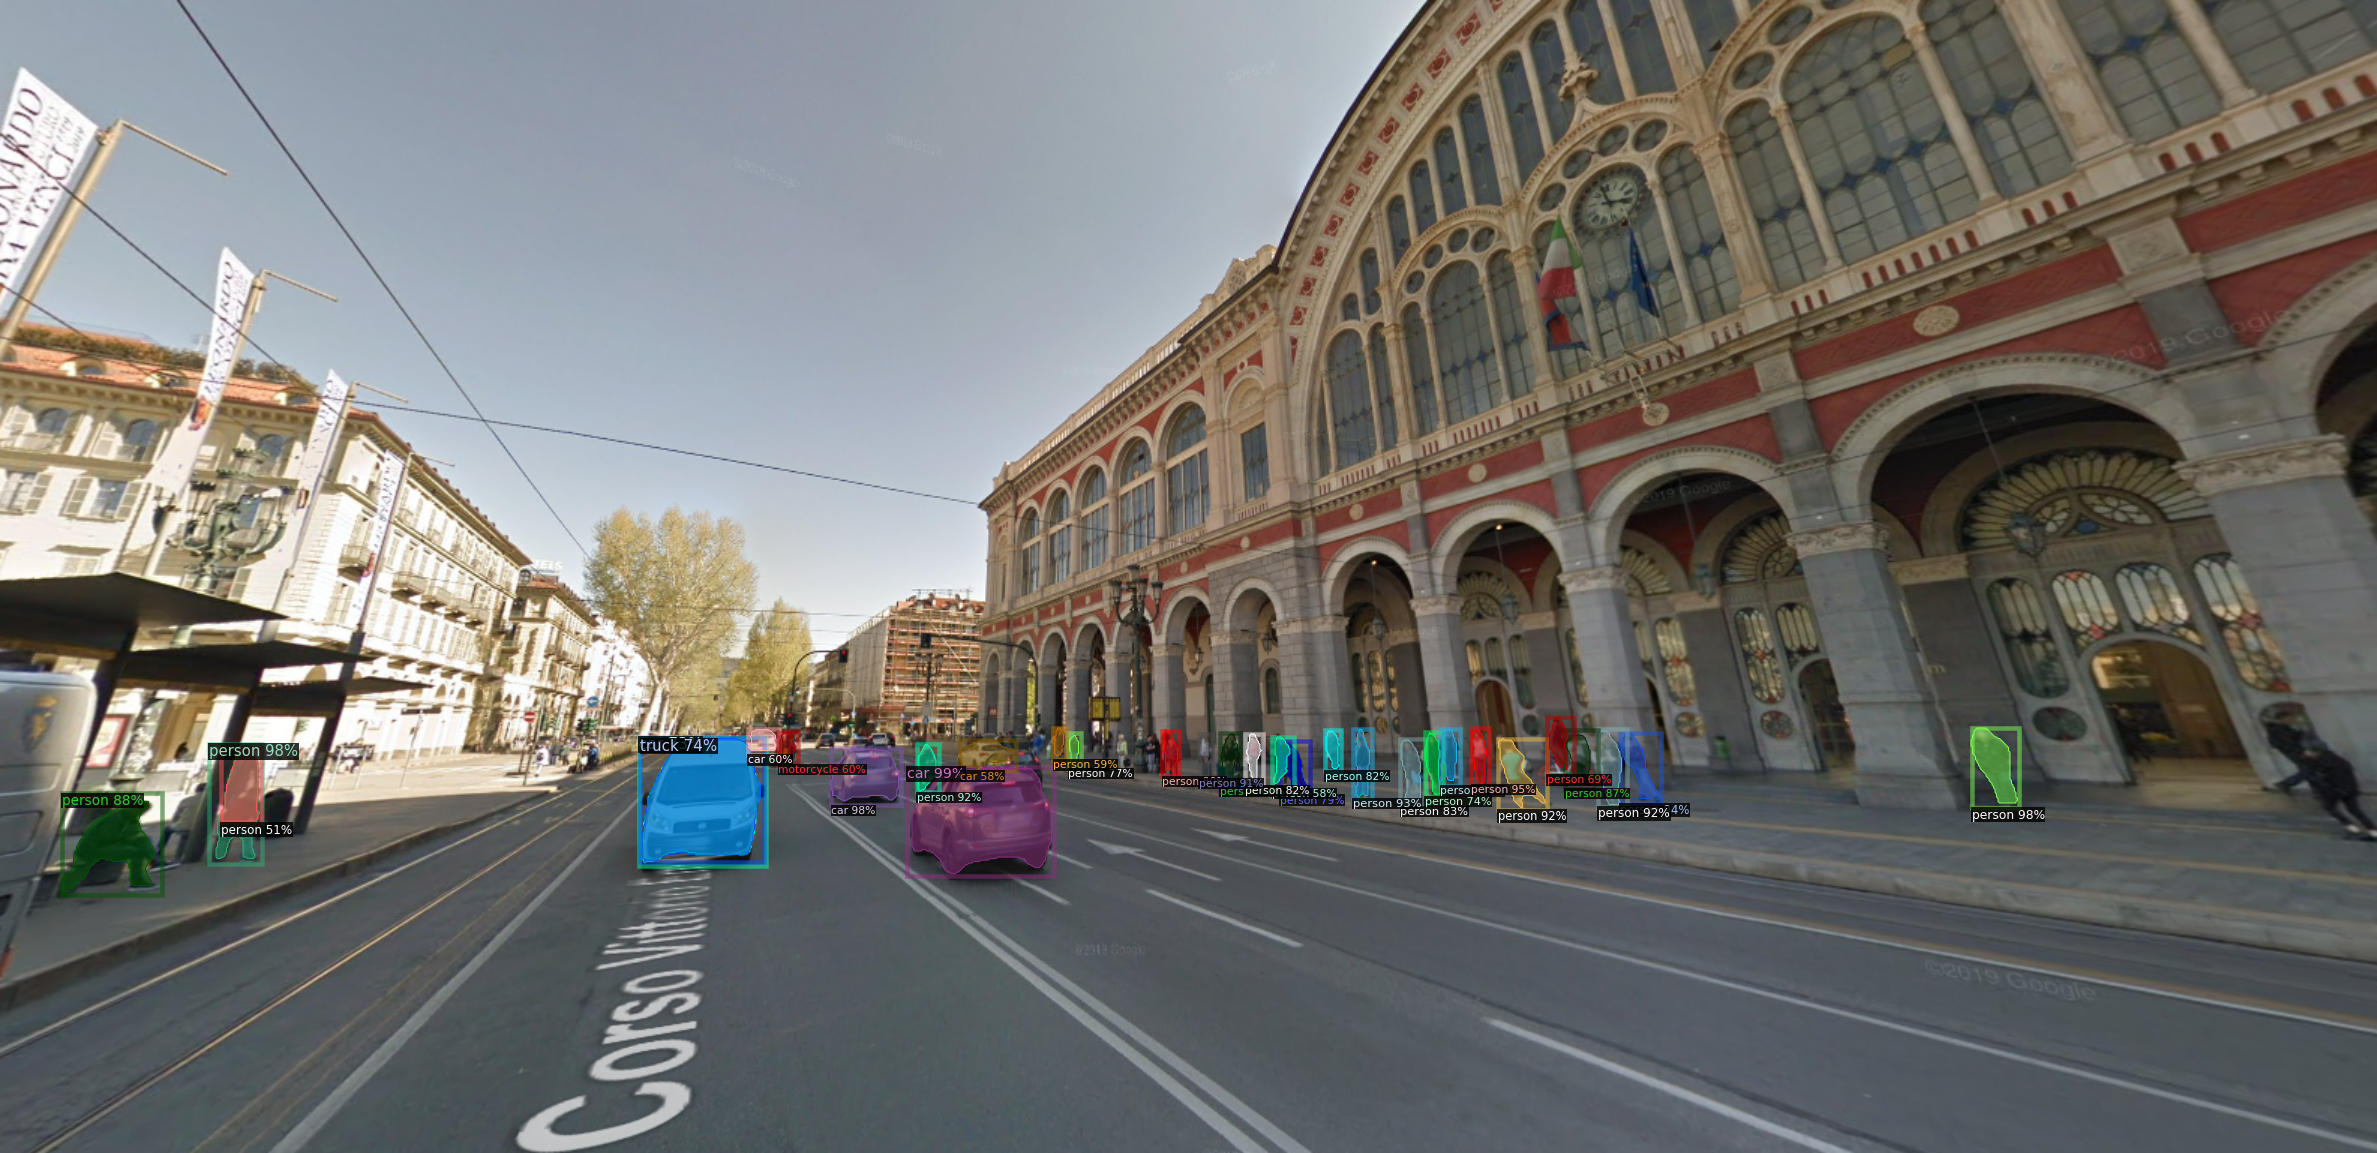

In [0]:
v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image())

# Where to go now?

Computer vision is a field which behind the obstacles one can have at learning it, also has some entry barriers: often it is difficult to have access to specific hardware, a model can take hours to train, and our small laptops can often freeze, hence it is hard to follow the "classical" trial and error learning path that maybe we followed while experimenting with some machine learning algorithms while cracking scikit-learn!
Since (hopefully) you have now a basic idea of the workflow, from how to import an image to how to display it, as long as how to load a model from detectron2 library, the next step could be trying to retrain it, using (I suggest) some cloud providers, it can be Google Colab, Paperspace Gradient, Azure Notebooks or anything else. Another good forward step could be to try implementing the Detectron2 "rival" Yolo, and maybe implement it in an iOS app using coremltools.